In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats import pearsonr
from scipy.sparse import linalg
from scipy.linalg import solve, pinv
import matplotlib.pyplot as plt
from numba import jit, float64
from CG import CG
from ASM import ASM
import SINewton

ModuleNotFoundError: No module named 'CG'

In [2]:
def dxdt_lorenz(x,time,r_t, sigma = 10., beta = 8/3, rho = 28.):
    return np.array([sigma*(- x[0] + x[1]),\
                     r_t(time)*rho*x[0] - x[1] - x[0]*x[2],\
                     x[0]*x[1]-beta*x[2]])

def rk4(x, time, tau, r_t, dxdt):
    k1 = dxdt(x, time, r_t)
    k2 = dxdt(x + k1/2*tau, time + tau/2, r_t)
    k3 = dxdt(x + k2/2*tau, time + tau/2, r_t)
    k4 = dxdt(x + tau*k3, time + tau, r_t)
    
    xnext = x + 1/6*tau*(k1+2*k2+2*k3+k4)
    return xnext

def getLorenzData(data_length, r_t, dxdt_lorenz,transient_length = 1000, tau = 0.1):
    x = np.random.rand(3)
    time = -transient_length*tau
    for i in range(0,transient_length):
        x = rk4(x,time,tau,r_t,dxdt_lorenz)
        time += tau
    
    data = np.zeros((3,data_length))
    data[:,0] = x
    for i in range(0,data_length-1):
        data[:,i+1] = rk4(data[:,i],time,tau,r_t,dxdt_lorenz)
        time += tau
        
    return data

def r_t_cosine(time, period = 500, max_height = 48/28):
    r = 1 + (max_height-1.)/2 - (max_height-1)/2*np.cos(2*np.pi/period*time)
    return r

def r_t_const(time, value = 1.):
    # Function for constant rho value
    r = value
    return r

def advanceReservoir(win,A_mat,x,u,leakage):
    x_next = leakage*x + (1-leakage)*np.tanh(A_mat.dot(x) + np.matmul(win,u))
    return x_next

def getPrediction(win, A_mat, wout, x, predict_length, leakage):
    prediction = np.zeros((wout.shape[0],predict_length))
    aug_x = np.copy(x)
    aug_x[::2] = np.power(x[::2],2)
    prediction[:,0] = np.matmul(wout,aug_x)
    
    for pred_idx in range(0,predict_length - 1):
        x = advanceReservoir(win, A_mat, x, prediction[:,pred_idx], leakage)
        aug_x = np.copy(x)
        aug_x[::2] = np.power(x[::2],2)
        prediction[:,pred_idx + 1] = np.matmul(wout,aug_x)
        
    return prediction

def evaluatePrediction(win, A_mat, wout, x, predict_length, leakage, truth, error_cutoff, true_var):
    prediction = getPrediction(win,A_mat,wout,x,predict_length,leakage)
                    
    error = np.linalg.norm(prediction - truth, axis = 0)/true_var
    valid_time = 0.
    for i in range(predict_length):
        if error[i] > error_cutoff:
            break
        else:
            valid_time += 1
            
    return prediction, error, valid_time

def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
        
    return freq

@jit(nopython = True, fastmath = True)
def UDfactor(P):
    P_base = np.copy(P)
    n = P.shape[0]
    d = np.zeros(n)
    U = np.eye(n)
    for j in range(n-1,0,-1):
        d[j] = P[j,j]
        U[:j,j] = P[:j,j]/d[j]
        for k in range(j):
            P[:k+1,k] = P[:k+1,k] - U[:k+1,j]*U[k,j]*d[j]
    d[0] = P[0,0]
        
    return U, np.diag(d), P_base

def UDupdate(U,D,r,forget):
    f = np.dot(U.T,r)
    g = np.dot(D,f)
    beta = np.dot(f,g) + forget
    G = np.outer(g,g)/beta
    U_bar,D_bar,G = UDfactor(D - G)
    return U @ U_bar, D_bar/forget

In [3]:
samples = np.random.rand(3,20)
P_test = samples @ samples.T
#P_test = np.array([[1,2,1],[0,1,1],[0,0,1]]) @ np.eye(3) @ np.array([[1,2,1],[0,1,1],[0,0,1]]).T
U, D , P_test = UDfactor_test(P_test)
U, D , P_test = UDfactor(P_test)
print(np.linalg.inv(P_test))
print(U.T @ np.linalg.inv(D) @ U)

NameError: name 'UDfactor_test' is not defined

In [7]:
input_weight = 1e-2
spectral_radius = 0.9
regularization = 1e-5
average_degree = 3
leakage = 0
forgets = np.array([0.999,0.99,0.985,0.98])
LM_reg = 1e-9
regularization = LM_reg/(1.-forgets)
delta = (1.-forgets)/(LM_reg)
# forgets = np.array([0.9825])
inv_forgets = 1/forgets
data_seed = 30
cumulative = False
w_LM_reg = True
approx_LM_reg = True
UD_factor = True
LM_regs = np.array([LM_reg])

step = 0.05
transient_length = int(50/step)
data_length = int(3000/step)
train_length = int(200/step)
start_length = int(50/step)
predict_length = int(20/step)
predict_gap_length = int(2/step)
num_predictions = 250
num_trials = 100
num_forgets = forgets.shape[0]
approx_num_nodes = 300

In [5]:
np.random.seed(data_seed)
train_input_sequence = getLorenzData(data_length,r_t_const,dxdt_lorenz,tau = 0.05)

input_size = train_input_sequence.shape[0]
num_nodes = int(np.ceil(approx_num_nodes/input_size)*input_size);

A_mat = sparse.random(num_nodes,num_nodes, density = average_degree/num_nodes)
eg = linalg.eigs(A_mat, k = 1, return_eigenvectors=False)
A_mat = spectral_radius/np.abs(eg[0])*A_mat

q = int(np.floor(num_nodes/(input_size)))
win = np.zeros((num_nodes,input_size))
for i in range(input_size):
    np.random.seed(i)
    ip = (-1 + 2*np.random.randn(q));
    win[i*q:(i+1)*q,i] = input_weight*ip;

In [6]:
predictions = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
truths = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
errors = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
valid_times = np.zeros((num_predictions,num_trials,num_forgets))

# predictions_exactinv = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
# errors_exactinv = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
# valid_times_exactinv = np.zeros((num_predictions,num_trials,num_forgets))

for data_seed in range(num_trials):
    np.random.seed(data_seed)
    train_input_sequence = getLorenzData(data_length,r_t_const,dxdt_lorenz,tau = 0.05)
    true_var = np.sqrt(np.mean(train_input_sequence**2))
    for k in range(num_forgets):
        for LM_reg in LM_regs:
            times = np.zeros(num_predictions)

            x = np.zeros(num_nodes)
            # states = np.zeros((num_nodes, start_length))

            for t in range(transient_length-1):
                x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)
            data_trstates = np.zeros((input_size,num_nodes))
            states_trstates_inv = delta[k]*np.identity(num_nodes)
            # states_trstates_inv_exactinv = delta[k]*np.identity(num_nodes)
            error_cutoff = 0.2;
            if w_LM_reg:
                LM_idenmat = sparse.identity(num_nodes)
            for pred in range(num_predictions):
                start_pred_idx = transient_length + pred*predict_gap_length - 1
                times[pred] = start_pred_idx*step
                for i in range(predict_gap_length):
                    x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
                    aug_x = np.copy(x)
                    aug_x[::2] = np.power(x[::2],2)
                    data_trstates = forgets[k]*data_trstates + \
                        np.outer(train_input_sequence[:,start_pred_idx + i + 1],aug_x)
                    states_trstates_inv = inv_forgets[k]*(states_trstates_inv - 1.0/\
                        (1+inv_forgets[k]*np.dot(np.dot(aug_x,states_trstates_inv),aug_x))*\
                        np.outer(np.dot(states_trstates_inv,aug_x),np.dot(aug_x,states_trstates_inv))\
                        *inv_forgets[k])
                    # states_trstates_inv_exactinv = inv_forgets[k]*(states_trstates_inv_exactinv - 1.0/\
                        # (1+inv_forgets[k]*np.dot(np.dot(aug_x,states_trstates_inv_exactinv),aug_x))*\
                        # np.outer(np.dot(states_trstates_inv_exactinv,aug_x),np.dot(aug_x,states_trstates_inv_exactinv))\
                        # *inv_forgets[k])
                    states_trstates_inv = states_trstates_inv - \
                        LM_reg*np.matmul(states_trstates_inv,states_trstates_inv)
                    # states_trstates_inv_exactinv = np.transpose(solve(np.transpose(LM_reg*states_trstates_inv_exactinv + \
                        # LM_idenmat),np.transpose(states_trstates_inv_exactinv)))
                wout = np.matmul(data_trstates,states_trstates_inv)

                # wout_exactinv = np.matmul(data_trstates,states_trstates_inv_exactinv)
                # if pred == num_predictions - 1:
                    # print(np.linalg.norm(wout-wout_exactinv))
                
                
                truths[:,:,pred,data_seed,k] = train_input_sequence[:,start_pred_idx + predict_gap_length:start_pred_idx +predict_gap_length + predict_length]
                predictions[:,:,pred,data_seed,k], errors[:,pred,data_seed,k], valid_times[pred,data_seed,k] =\
                    evaluatePrediction(win, A_mat, wout, x, predict_length, leakage, truths[:,:,pred,data_seed,k], error_cutoff, true_var)
                # predictions_exactinv[:,:,pred,data_seed,k], errors_exactinv[:,pred,data_seed,k], valid_times_exactinv[pred,data_seed,k] =\
                    # evaluatePrediction(win, A_mat, wout_exactinv, x, predict_length, leakage, truths[:,:,pred,data_seed,k], error_cutoff)



                
                # np.savetxt('Lorenz63Data/lorenz_prediction_lam%f_reg%f_seed%d_pred%d.csv' % (forgets[k],LM_reg,data_seed,pred),prediction,delimiter = ',')
                # np.savetxt('Lorenz63Data/lorenz_error_lam%f_reg%f_seed%d_pred%d.csv' % (forgets[k],LM_reg,data_seed,pred),error,delimiter = ',')
                # if k == 0 and LM_reg == LM_regs[0]:
                    # np.savetxt('Lorenz63Data/lorenz_truth_seed%d_pred%d.csv' % (data_seed,pred),truth,delimiter = ',')
            print(data_seed, k)
            #np.savetxt('Lorenz63Data/lorenz_valid_times_period500_winnergarbage_lam%f_reg%e_seed%d.csv' % (forgets[k],LM_reg,data_seed),valid_times[:,data_seed,k],delimiter = ',')
for i in range(num_forgets):
    valid_time_save = valid_times[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_reg%e_delta%e_step%f.csv' % (forgets[i],LM_reg,delta[i],step),valid_time_save,delimiter = ',')
    for j in range(num_trials):
        error_save = errors[:,:,j,i]
        np.savetxt('Lorenz63Data/lorenz_error_constr_lam%f_reg%e_trial%d_step%f.csv' % (forgets[i],LM_reg,j,step), error_save)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0


In [22]:
predictions = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
truths = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
errors = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
valid_times = np.zeros((num_predictions,num_trials,num_forgets))

# predictions_exactinv = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
# errors_exactinv = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
# valid_times_exactinv = np.zeros((num_predictions,num_trials,num_forgets))

for data_seed in range(num_trials):
    np.random.seed(data_seed)
    train_input_sequence = getLorenzData(data_length,r_t_const,dxdt_lorenz,tau = 0.05)
    true_var = np.sqrt(np.mean(train_input_sequence**2))
    for k in range(num_forgets):
        for LM_reg in LM_regs:
            times = np.zeros(num_predictions)

            x = np.zeros(num_nodes)
            # states = np.zeros((num_nodes, start_length))

            for t in range(transient_length-1):
                x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)
            data_trstates = np.zeros((input_size,num_nodes))
            states_trstates_inv = delta[k]*np.identity(num_nodes)
            U, D, states_trstates_inv = UDfactor(states_trstates_inv)
            # states_trstates_inv_exactinv = delta[k]*np.identity(num_nodes)
            error_cutoff = 0.2;
            if w_LM_reg:
                LM_idenmat = sparse.identity(num_nodes)
            for pred in range(num_predictions):
                start_pred_idx = transient_length + pred*predict_gap_length - 1
                times[pred] = start_pred_idx*step
                for i in range(predict_gap_length):
                    x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
                    aug_x = np.copy(x)
                    aug_x[::2] = np.power(x[::2],2)
                    data_trstates = forgets[k]*data_trstates + \
                        np.outer(train_input_sequence[:,start_pred_idx + i + 1],aug_x)
                    U, D = UDupdate(U,D,aug_x,forgets[k])
                    # states_trstates_inv = states_trstates_inv - \
                        # LM_reg*np.matmul(states_trstates_inv,states_trstates_inv)
                    
                    # U, D, states_trstates_inv = UDfactor(states_trstates_inv)
                    # states_trstates_inv_exactinv = np.transpose(solve(np.transpose(LM_reg*states_trstates_inv_exactinv + \
                        # LM_idenmat),np.transpose(states_trstates_inv_exactinv)))
                states_trstates_inv = U @ D @ U.T
                states_trstates_inv = states_trstates_inv - \
                        LM_reg*predict_gap_length*np.matmul(states_trstates_inv,states_trstates_inv)
                # U, D, states_trstates_inv = UDfactor(states_trstates_inv)
                wout = np.matmul(data_trstates,states_trstates_inv)
                
                # wout_exactinv = np.matmul(data_trstates,states_trstates_inv_exactinv)
                # if pred == num_predictions - 1:
                    # print(np.linalg.norm(wout-wout_exactinv))
                
                
                truths[:,:,pred,data_seed,k] = train_input_sequence[:,start_pred_idx + predict_gap_length:start_pred_idx +predict_gap_length + predict_length]
                predictions[:,:,pred,data_seed,k], errors[:,pred,data_seed,k], valid_times[pred,data_seed,k] =\
                    evaluatePrediction(win, A_mat, wout, x, predict_length, leakage, truths[:,:,pred,data_seed,k], error_cutoff, true_var)
                # predictions_exactinv[:,:,pred,data_seed,k], errors_exactinv[:,pred,data_seed,k], valid_times_exactinv[pred,data_seed,k] =\
                    # evaluatePrediction(win, A_mat, wout_exactinv, x, predict_length, leakage, truths[:,:,pred,data_seed,k], error_cutoff)



                
                # np.savetxt('Lorenz63Data/lorenz_prediction_lam%f_reg%f_seed%d_pred%d.csv' % (forgets[k],LM_reg,data_seed,pred),prediction,delimiter = ',')
                # np.savetxt('Lorenz63Data/lorenz_error_lam%f_reg%f_seed%d_pred%d.csv' % (forgets[k],LM_reg,data_seed,pred),error,delimiter = ',')
                # if k == 0 and LM_reg == LM_regs[0]:
                    # np.savetxt('Lorenz63Data/lorenz_truth_seed%d_pred%d.csv' % (data_seed,pred),truth,delimiter = ',')
            print(data_seed, k)
            #np.savetxt('Lorenz63Data/lorenz_valid_times_period500_winnergarbage_lam%f_reg%e_seed%d.csv' % (forgets[k],LM_reg,data_seed),valid_times[:,data_seed,k],delimiter = ',')
for i in range(num_forgets):
    valid_time_save = valid_times[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_UD_constr_lam%f_reg%e_delta%e_step%f.csv' % (forgets[i],LM_reg,delta[i],step),valid_time_save,delimiter = ',')
    for j in range(num_trials):
        error_save = errors[:,:,j,i]
        np.savetxt('Lorenz63Data/lorenz_error_UD_constr_lam%f_reg%e_trial%d_step%f.csv' % (forgets[i],LM_reg,j,step), error_save)

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0


KeyboardInterrupt: 

In [23]:
for i in range(num_forgets):
    valid_time_save = valid_times[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_UD_constr_lam%f_reg%e_delta%e_step%f.csv' % (forgets[i],LM_reg,delta[i],step),valid_time_save,delimiter = ',')
    for j in range(51):
        error_save = errors[:,:,j,i]
        np.savetxt('Lorenz63Data/lorenz_error_UD_constr_lam%f_reg%e_trial%d_step%f.csv' % (forgets[i],LM_reg,j,step), error_save)

In [ ]:
avg_errors = np.zeros((predict_length, num_predictions, num_forgets+1))
avg_errors[:,:,1:] = np.mean(errors, axis = 2)
for j in range(num_trials):
    temp_error = np.loadtxt('Lorenz63Data/lorenz_error_constr_lam%f_tikreg%e_trial%d_step%f.csv' % (1.,1e-6,j,step))
    avg_errors[:,:,0] = avg_errors[:,:,0] + temp_error/num_trials
    

In [ ]:
plot_pred = 200
plt.figure(figsize = (9,7))
for i in range(avg_errors.shape[2]):
    if i ==0:
        plt_lambda = 1.
    else:
        plt_lambda = forgets[i-1]
    plt.plot(step*np.arange(avg_errors.shape[0])+step,avg_errors[:,plot_pred,i],label = '$\lambda = %f$' % plt_lambda)
plt.xlabel('Lorenz Time')
plt.ylabel('Average RMS Error in Prediction')
plt.title('Training Time: %d' % (plot_pred*predict_gap_length*step) )
# plt.yscale('log')
plt.rc('font',size = 16)
plt.xlim(step,20)
plt.legend()
plt.savefig('lorenz_prediction_error_traintime%d_step%f.pdf' % (plot_pred*predict_gap_length*step, step))
plt.show()

In [ ]:
valid_times_plot = np.zeros((num_predictions,num_forgets+1))
for i in range(num_forgets):
    temp_valid_times = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_reg5.000000e-10_delta%e_step0.050000.csv' % (forgets[i],1/(5e-10/(1-forgets[i]))),delimiter = ',')
    valid_times_plot[:,i+1] = np.mean(temp_valid_times,axis = 1)
temp_valid_times = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam1.000000_tikreg1.000000e-06_step0.050000.csv',delimiter = ',')
valid_times_plot[:,0] = np.mean(temp_valid_times,axis = 1)

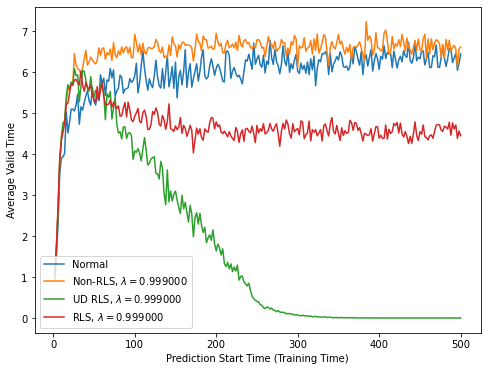

In [30]:
plot_times = (np.arange(num_predictions)+1)*predict_gap_length*step
forgets = np.array([0.999])
num_forgets = len(forgets)
regularization = 5e-11/(1-forgets)
delta = (1.-forgets)/(5e-11)
valid_times_plot = np.zeros((num_predictions,num_forgets))
valid_times_1 = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_tikreg%e_step%f.csv' % (1.0,1e-6,step),delimiter = ',')
for i in range(num_forgets):
    plt.figure(figsize = (8,6))
    plt_lambda = forgets[i]
    plt.plot(plot_times, np.mean(valid_times_1, axis = 1)*step, label = 'Normal')
    temp_valid_times = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_tikreg%e_step%f.csv' % (forgets[i],regularization[i],step),delimiter = ',')
    plt.plot(plot_times,np.mean(temp_valid_times, axis = 1)*step,label = 'Non-RLS, $\lambda = %f$' % plt_lambda)
    temp_valid_times = np.loadtxt('Lorenz63Data/lorenz_valid_times_UD_constr_lam%f_reg%e_delta%e_step%f.csv' % (forgets[i],LM_reg,delta[i],step),delimiter = ',')
    plt.plot(plot_times,np.mean(temp_valid_times[:,:51], axis = 1)*step,label = 'UD RLS, $\lambda = %f$' % plt_lambda)
    # temp_valid_times = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_reg%e_delta%e_step%f.csv' % (forgets[i],LM_reg,delta[i],step),delimiter = ',')
    temp_valid_times = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam0.999000_reg5.000000e-11_delta2.000000e+07_step0.050000.csv',delimiter = ',')
    plt.plot(plot_times,np.mean(temp_valid_times, axis = 1)*step,label = 'RLS, $\lambda = %f$' % plt_lambda)
    plt.xlabel('Prediction Start Time (Training Time)')
    plt.ylabel('Average Valid Time')
    plt.legend()
    plt.savefig('lorenz_valid_times_constr_lam%f_LMreg%e_vsUD.pdf' % (plt_lambda, 1e-10))
    plt.show()

In [8]:
predictions_norm = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
truths_norm = np.zeros((input_size,predict_length,num_predictions,num_trials,num_forgets))
errors_norm = np.zeros((predict_length,num_predictions,num_trials,num_forgets))
valid_times_norm = np.zeros((num_predictions,num_trials,num_forgets))
ic_errors_norm = np.zeros((num_predictions,num_trials,num_forgets))
for data_seed in range(num_trials):
    np.random.seed(data_seed)
    train_input_sequence = getLorenzData(data_length,r_t_const,dxdt_lorenz,tau = 0.05)
    true_var = np.sqrt(np.mean(train_input_sequence**2))
    for k in range(num_forgets):
        times = np.zeros(num_predictions)

        x = np.zeros(num_nodes)
        # states = np.zeros((num_nodes, start_length))

        for t in range(transient_length-1):
            x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)

        error_cutoff = 0.2;
        aug_states = np.zeros((num_nodes,predict_gap_length*num_predictions))

        for pred in range(num_predictions):
            start_pred_idx = transient_length + pred*predict_gap_length-1
            times[pred] = start_pred_idx*step
            for i in range(predict_gap_length):
                x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
                aug_x = np.copy(x)
                aug_x[::2] = np.power(x[::2],2)
                aug_states[:,i + pred*predict_gap_length] = aug_x
            s_mat = sparse.diags(np.power(forgets[k],np.arange((pred+1)*predict_gap_length)[::-1]))
            data_trstates_norm = train_input_sequence[:,transient_length:transient_length+(pred+1)*predict_gap_length] @ \
                      s_mat @ aug_states[:,:(pred+1)*predict_gap_length].T
            states_trstates_norm = aug_states[:,:(pred+1)*predict_gap_length] @ s_mat @ aug_states[:,:(pred+1)*predict_gap_length].T\
                      + regularization[k]*sparse.identity(num_nodes)
            wout_norm = np.transpose(solve(states_trstates_norm.T,data_trstates_norm.T))
            

        # train_pred = wout_norm @ aug_states[:,:(pred+1)*predict_gap_length]
        # truth = train_input_sequence[:,transient_length:transient_length+(pred+1)*predict_gap_length]
        # train_errors_norm[:,data_seed,k] = np.linalg.norm(train_pred - truth, axis = 0)/np.sqrt(np.mean(truth**2))
            truths_norm[:,:,pred,data_seed,k] = train_input_sequence[:,start_pred_idx + predict_gap_length:start_pred_idx + predict_gap_length + predict_length]
            predictions_norm[:,:,pred,data_seed,k], errors_norm[:,pred,data_seed,k], valid_times_norm[pred,data_seed,k] =\
                evaluatePrediction(win, A_mat, wout_norm, x, predict_length, leakage, truths_norm[:,:,pred,data_seed,k], error_cutoff, true_var)
            ic_errors_norm[pred,data_seed,k] = errors_norm[0,pred,data_seed,k]
        print(k, data_seed)
for i in range(num_forgets):
    valid_time_save = valid_times_norm[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_tikreg%e_step%f.csv' % (forgets[i],regularization[i],step),valid_time_save,delimiter = ',')
    for j in range(num_trials):
        error_save = errors_norm[:,:,j,i]
        np.savetxt('Lorenz63Data/lorenz_error_constr_lam%f_tikreg%e_trial%d_step%f.csv' % (forgets[i],regularization[i],j,step), error_save)

0 0
1 0
2 0
3 0
0 1
1 1
2 1
3 1
0 2
1 2
2 2
3 2
0 3
1 3
2 3
3 3
0 4
1 4
2 4
3 4
0 5
1 5
2 5
3 5
0 6
1 6
2 6
3 6
0 7
1 7
2 7
3 7
0 8
1 8
2 8
3 8
0 9
1 9
2 9
3 9
0 10
1 10
2 10
3 10
0 11
1 11
2 11
3 11
0 12
1 12
2 12
3 12
0 13
1 13
2 13
3 13
0 14
1 14
2 14
3 14
0 15
1 15
2 15
3 15
0 16
1 16
2 16
3 16
0 17
1 17
2 17
3 17
0 18
1 18
2 18
3 18
0 19
1 19
2 19
3 19
0 20
1 20
2 20
3 20
0 21
1 21
2 21
3 21
0 22
1 22
2 22
3 22
0 23
1 23
2 23
3 23
0 24
1 24
2 24
3 24
0 25
1 25
2 25
3 25
0 26
1 26
2 26
3 26
0 27
1 27
2 27
3 27
0 28
1 28
2 28
3 28
0 29
1 29
2 29
3 29
0 30
1 30
2 30
3 30
0 31
1 31
2 31
3 31
0 32
1 32
2 32
3 32
0 33
1 33
2 33
3 33
0 34
1 34
2 34
3 34
0 35
1 35
2 35
3 35
0 36
1 36
2 36
3 36
0 37
1 37
2 37
3 37
0 38
1 38
2 38
3 38
0 39
1 39
2 39
3 39
0 40
1 40
2 40
3 40
0 41
1 41
2 41
3 41
0 42
1 42
2 42
3 42
0 43
1 43
2 43
3 43
0 44
1 44
2 44
3 44
0 45
1 45
2 45
3 45
0 46
1 46
2 46
3 46
0 47
1 47
2 47
3 47
0 48
1 48
2 48
3 48
0 49
1 49
2 49
3 49
0 50
1 50
2 50
3 50
0 51
1 51
2 51
3 51


In [ ]:
train_out = wout_norm @ aug_states
plt.plot(train_out[0,:1000])
plt.plot(train_input_sequence[0,transient_length:transient_length + 1000])
plt.show

In [ ]:
for i in range(num_forgets):
    valid_time_save = valid_times[:,:,i]
    np.savetxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_reg%e.csv' % (forgets[i],LM_reg),valid_time_save,delimiter = ',')

In [ ]:
itr = 200
run = 10
fgt = 3
fgtm = step*np.log(1/2)/np.log(forgets[fgt])
plt.plot(np.arange(predict_length)*step,truths_norm[0,:,itr,run],label = 'Truth')
plt.plot(np.arange(predict_length)*step,predictions_norm[0,:,itr,run],label = 'Reservoir')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.legend()
plt.show()

plt.plot(np.arange(predict_length)*step,truths[0,:,itr,run,fgt],label = 'Truth')
plt.plot(np.arange(predict_length)*step,predictions[0,:,itr,run,fgt],label = 'Reservoir')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.legend()
plt.show()

In [ ]:
forget = 1
reg = 1e-10
deltaplot = 1e-2
times = np.arange(2,2*251,2)
fgtm = step*np.log(1/2)/np.log(forget)
if deltaplot == 1.:
    valid_time_save = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_reg%e.csv' % (forget,reg),delimiter = ',')
else:
    valid_time_save = np.loadtxt('Lorenz63Data/lorenz_valid_times_constr_lam%f_reg%e_delta%e.csv' % (forget,reg,deltaplot),delimiter = ',')
valid_time_norm_save = np.loadtxt('Lorenz63Data/lorenz_valid_times_norm_rconst_lam%f_tikreg%e.csv' % (1.,regularization),delimiter = ',')
plt.plot(times,np.mean(valid_time_norm_save[:,:],axis = 1)*step,label = 'Normal')
plt.plot(times,np.mean(valid_time_save,axis = 1)*step,label = 'RLS, $t_\lambda = %f$' % fgtm)
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.legend()
if deltaplot == 1.:
    plt.savefig('lorenz_valid_times_lam%f_reg%e.pdf' % (forget,reg))
else:
    plt.savefig('lorenz_valid_times_lam%f_reg%e_delta%e.pdf' % (forget,reg,deltaplot))
plt.show()

In [ ]:
print(times)

In [ ]:
best_valid_times = np.zeros((3,num_predictions))
max_avg_valid_times = np.zeros(num_predictions)
for k in range(num_forgets):
    for LM_reg in LM_regs:
        new_avg_valid_times = np.zeros(num_predictions)
        for data_seed in range(num_trials):
            new_avg_valid_times = new_avg_valid_times + np.loadtxt('Lorenz63Data/lorenz_valid_times_period2000_lam%f_reg%e_seed%d.csv' % (forgets[k],LM_reg,data_seed),delimiter = ',')
        new_avg_valid_times = new_avg_valid_times/num_trials
        max_avg_valid_times = np.maximum(max_avg_valid_times,new_avg_valid_times)
        for pred in range(num_predictions):
            if max_avg_valid_times[pred] == new_avg_valid_times[pred]:
                best_valid_times[0,pred] = data_seed
                best_valid_times[1,pred] = forgets[k]
                best_valid_times[2,pred] = LM_reg

In [ ]:
# print(best_valid_times)


In [ ]:
wouts_abs = np.sqrt(np.mean((wouts - wouts_norm)**2,axis = (0,1)))
plt.plot(wouts_abs)
plt.show()

In [ ]:
itr = 47
run = 15
fg  = 7
times_all = step*(transient_length + start_length + np.arange(num_predictions)*predict_gap_length)
plt.plot(times_all,r_t_cosine(times))
plt.plot(times[itr],r_t_cosine(times[itr]),'r.')
plt.xlabel('Time')
plt.ylabel('r(t)')
plt.savefig('r_t_cosine_itr%d_run%d_forget%d.pdf' % (itr,run,fg))
plt.show()
plt.plot(np.arange(predict_length)*step,truths[0,:,itr,run,fg],label = 'Truth')
plt.plot(np.arange(predict_length)*step,predictions[0,:,itr,run,fg],label = 'Reservoir w/ RLS')
plt.xlabel('Time')
plt.ylabel('x(t)')
tlfg = step*np.log(1/2)/np.log(forgets[fg])
plt.title('$t_\lambda = %f$' % tlfg)
plt.legend()
plt.savefig('x_t_truth_vs_pred_winnergarbage_itr%d_run%d_forget%d_reg1e-8_wapproxLMreg.pdf' % (itr,run,fg))
plt.show()

In [ ]:
idx1 = 3
tl1 = step*np.log(1/2)/np.log(forgets[idx1])
idx2 = 7
tl2 = step*np.log(1/2)/np.log(forgets[idx2])
# plt.errorbar(times,np.mean(valid_times[:,:,0],axis = 1)*step,step*np.std(valid_times[:,:,0],axis = 1),label = '$t_\lambda = \infty$')
plt.errorbar(times,np.mean(valid_times[:,:,idx1],axis = 1)*step,step*np.std(valid_times[:,:,idx1],axis = 1),label = '$t_\lambda = %f$' % tl1)
plt.errorbar(times,np.mean(valid_times[:,:,idx2],axis = 1)*step,step*np.std(valid_times[:,:,idx2],axis = 1),label = '$t_\lambda = %f$' % tl2)
plt.legend()
plt.xlabel('Prediction Start Time')
plt.ylabel('Valid Time')
plt.title('T = 500, 300 Reservoir Nodes, $\mu = 10^{-8}$')
plt.savefig('valid_time_vs_start_time_winnergarbage_reg1e-8_wapproxLMreg.pdf')
plt.show()

In [ ]:
plt.plot(predictions[0,:,80,5,6])
plt.plot(truths[0,:,80,5,6])
plt.show()